In [1]:
import numpy as np
import scipy
from scipy import stats, signal, fftpack
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
%matplotlib inline

 - https://en.wikipedia.org/wiki/Wiener_deconvolution
 - https://gist.github.com/danstowell/f2d81a897df9e23cc1da
 - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.periodogram.html
 - https://dsp.stackexchange.com/questions/17871/how-to-calculate-signal-to-noise-ratio
 - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.signaltonoise.html

In [2]:
fs = 10
dt = 600
t = np.linspace(0, dt, dt*fs+1)

In [3]:
xt = stats.norm(loc=20, scale=5).pdf(t)
xt.size

6001

In [4]:
gt = stats.lognorm(0.45, loc=-20, scale=100).pdf(t)
gt.size

6001

In [5]:
yt = signal.convolve(xt, gt, mode='full')
yt = yt[:t.size]/np.sum(yt[:t.size]/fs)
yt.size

6001

$$y(t) = g(t)*x(t) \xrightarrow{\mathcal{F}} Y(\nu) = G(\nu)\cdot X(\nu)$$

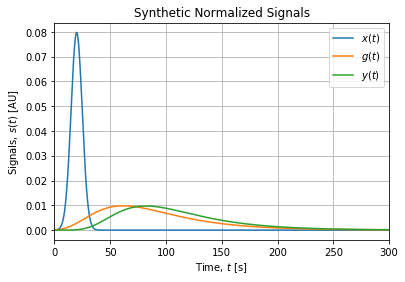

In [6]:
fig, axe = plt.subplots()
axe.plot(t, xt, label=r"$x(t)$")
axe.plot(t, gt, label=r"$g(t)$")
axe.plot(t, yt[:t.size], label=r"$y(t)$")
axe.set_xlim([0,300])
axe.set_title("Synthetic Normalized Signals")
axe.set_xlabel(r"Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Signals, $s(t)$ $[\mathrm{AU}]$")
axe.legend()
axe.grid()

In [7]:
Xs = fftpack.fft(xt)
Ys = fftpack.fft(yt)
fq = fs*fftpack.fftfreq(t.size)

In [8]:
l = 1e-4

$$ G(\nu) = \frac{Y(\nu)}{X(\nu)} $$

$$ G'(\nu) = \frac{X^*(\nu)\cdot Y(\nu)}{X^*(\nu)\cdot X(\nu) + \lambda^2} $$

$$ \lambda^2 = \frac{1}{\mathrm{SNR}} $$

$$\lim\limits_{\lambda \rightarrow 0} G'(\nu) = G(\nu)$$

In [9]:
Gs = (np.conj(Xs)*Ys)/(Xs*np.conj(Xs) + l**2)

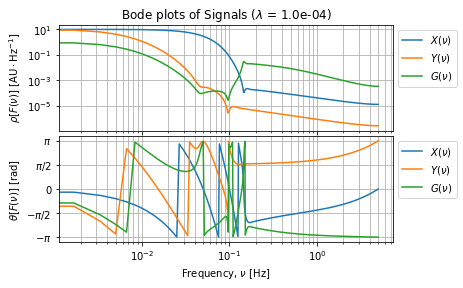

In [10]:
fig, axe = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.05})
axe[0].loglog(fq[:t.size//2], np.abs(Xs)[:t.size//2], label=r"$X(\nu)$")
axe[0].loglog(fq[:t.size//2], np.abs(Ys)[:t.size//2], label=r"$Y(\nu)$")
axe[0].loglog(fq[:t.size//2], np.abs(Gs)[:t.size//2], label=r"$G(\nu)$")
axe[1].plot(fq[:t.size//2], np.angle(Xs)[:t.size//2], label=r"$X(\nu)$")
axe[1].plot(fq[:t.size//2], np.angle(Ys)[:t.size//2], label=r"$Y(\nu)$")
axe[1].plot(fq[:t.size//2], np.angle(Gs)[:t.size//2], label=r"$G(\nu)$")
axe[0].set_title(r"Bode plots of Signals ($\lambda$ = {:.1e})".format(l))
axe[1].set_xlabel(r"Frequency, $\nu$ $[\mathrm{Hz}]$")
axe[0].set_ylabel(r"$\rho[F(\nu)]$ $[\mathrm{AU\cdot Hz^{-1}}]$")
axe[1].set_ylabel(r"$\theta[F(\nu)]$ $[\mathrm{rad}]$")
axe[1].set_yticks(np.linspace(-np.pi, np.pi, 5))
axe[1].set_yticklabels([r'$-\pi$',r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
for i in range(2):
    axe[i].legend(bbox_to_anchor=(1,1), loc='upper left')
    axe[i].grid(which='both')

In [11]:
f, Pxx = signal.periodogram(xt, fs)
f, Pyy = signal.periodogram(yt, fs)
f, Pgg = signal.periodogram(gt, fs)

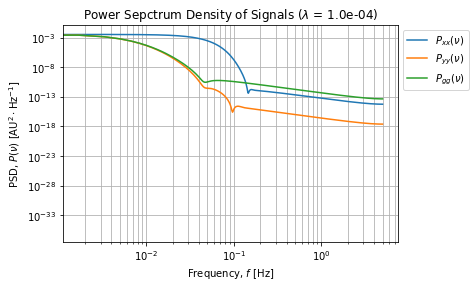

In [12]:
fig, axe = plt.subplots()
axe.loglog(f, Pxx, label=r"$P_{xx}(\nu)$")
axe.loglog(f, Pyy, label=r"$P_{yy}(\nu)$")
axe.loglog(f, Pgg, label=r"$P_{gg}(\nu)$")
axe.set_title("Power Sepctrum Density of Signals ($\lambda$ = {:.1e})".format(l))
axe.set_xlabel(r"Frequency, $f$ $[\mathrm{Hz}]$")
axe.set_ylabel(r"PSD, $P(\nu)$ $[\mathrm{AU^2\cdot Hz^{-1}}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid(which='both')

In [13]:
gti = fftpack.ifft(Gs)

In [14]:
gti

array([-0.00196946+4.64717760e-21j, -0.0012376 +2.41917465e-20j,
       -0.00069106+1.45981562e-20j, ..., -0.00086678+9.47903782e-20j,
       -0.00115051-2.82990979e-20j, -0.00151049+2.85211357e-19j])

In [15]:
np.allclose(np.imag(gti), 0)

True

In [16]:
gti = np.real(gti)

In [17]:
gti = gti/(gti.sum()/fs)

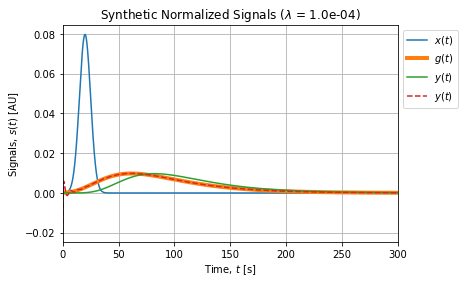

In [18]:
fig, axe = plt.subplots()
axe.plot(t, xt, label=r"$x(t)$")
axe.plot(t, gt, label=r"$g(t)$", linewidth=4)
axe.plot(t, yt, label=r"$y(t)$")
axe.plot(t, gti, '--', label=r"$y(t)$")
axe.set_xlim([0,300])
axe.set_title("Synthetic Normalized Signals ($\lambda$ = {:.1e})".format(l))
axe.set_xlabel(r"Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Signals, $s(t)$ $[\mathrm{AU}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

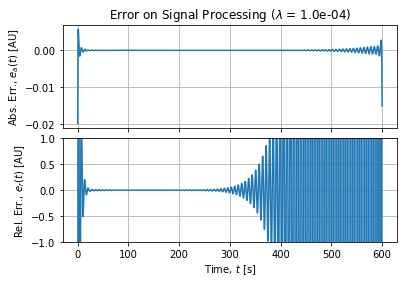

In [19]:
fig, axe = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.1})
axe[0].plot(t, gti-gt)
axe[1].plot(t, (gti-gt)/gt)
axe[1].set_ylim([-1,1])
axe[0].set_title("Error on Signal Processing ($\lambda$ = {:.1e})".format(l))
axe[1].set_xlabel(r"Time, $t$ $[\mathrm{s}]$")
axe[0].set_ylabel(r"Abs. Err., $e_a(t)$ $[\mathrm{AU}]$")
axe[1].set_ylabel(r"Rel. Err., $e_r(t)$ $[\mathrm{AU}]$")
for i in range(2):
    axe[i].grid()